Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Taking necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from tensorflow.keras.layers import *
from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
#unzipping the data folder that is shared to another folder.
!unzip -uq "/content/drive/My Drive/CNN_assignment" -d "/content/drive/My Drive/CNN_assignment_unzip"

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
!ls "/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Train dataset is loaded below.
## used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resized your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
## checking the type and shape of the dataset
print(type(train_ds))
print(train_ds)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

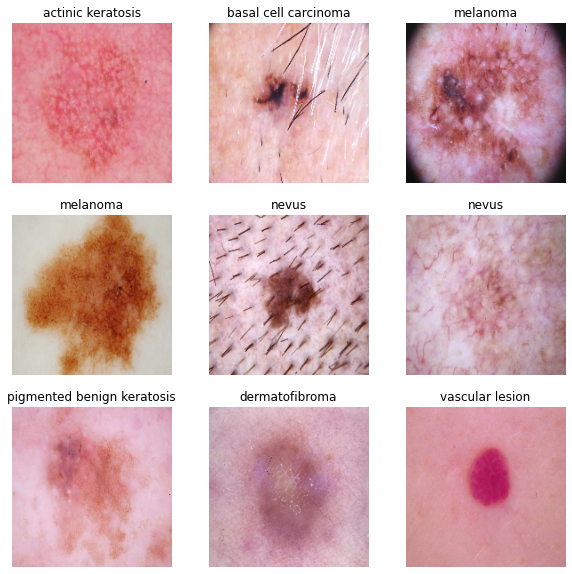

In [20]:
import matplotlib.pyplot as plt
num_classes=9
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Created a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [22]:
## normalizing the pixel value between (0,1)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
## We can Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.91923106


In [24]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
  
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [25]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0

### Train the model

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 125s 2s/step - loss: 2.0254 - accuracy: 0.2725 - val_loss: 1.6399 - val_accuracy: 0.3982
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5915 - accuracy: 0.4173 - val_loss: 1.5709 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4694 - accuracy: 0.4943 - val_loss: 1.3995 - val_accuracy: 0.5302
Epoch 4/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3190 - accuracy: 0.5224 - val_loss: 1.3750 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 1.2328 - accuracy: 0.5698 - val_loss: 1.4251 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 1.2372 - accuracy: 0.5635 - val_loss: 1.3669 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.0905 - accuracy: 0.6191 - val_loss: 1.3160 - val_accuracy: 0.5705
Epoch 8/20
56

### Visualizing training results

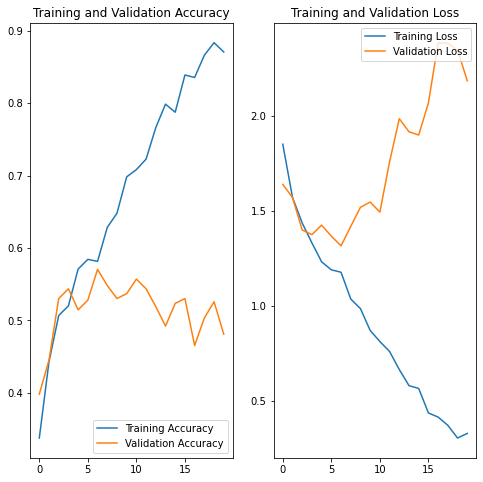

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. 
2. Also, the difference in accuracy between training and validation accuracy is noticeable as a sign of overfitting.
3. The Training accuracy is 88.45% and the Validation Accuracy is 48.52%

## Data augmentation

We will be doing data augmentation to try and see if the issue of Overfitting can be solved.

In [29]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

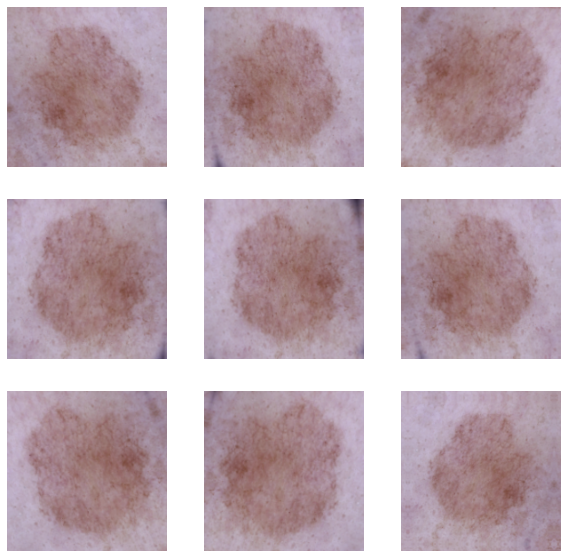

In [30]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [31]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  
  layers.Flatten(),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
  
])

### Compiling the model

In [32]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 43, 32)       

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 24ms/step - loss: 2.0163 - accuracy: 0.2496 - val_loss: 1.8283 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.7211 - accuracy: 0.3615 - val_loss: 1.6879 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5863 - accuracy: 0.4224 - val_loss: 1.6919 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4811 - accuracy: 0.4682 - val_loss: 1.5300 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4058 - accuracy: 0.5019 - val_loss: 1.5519 - val_accuracy: 0.4362
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3636 - accuracy: 0.5337 - val_loss: 1.5365 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3467 - accuracy: 0.5263 - val_loss: 1.4363 - val_accuracy: 0.4787
Epoch 8/20
56

### Visualizing the results

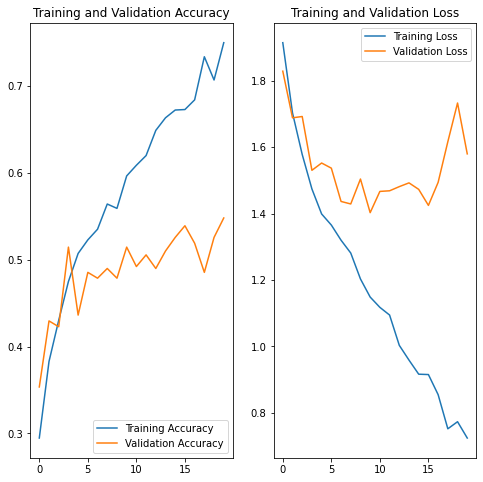

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


- There is some improvement in the Overfitting but the accuracy hasnt much improved.
- The current training accuracy is at 74.55% and Validation Accuracy at 54.81%
- It is probably due to Class imabalance.We will take care of class imbalance in the further steps



- Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 
- Class imbalance can have a detrimental effect on the final model quality. 
- Hence as a sanity check it becomes important to check what is the distribution of classes in the data.
- We will find the distribution of classes in the training datase 

In [36]:
## Here we will create a dataframe of original images and labels
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [37]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]
path_list

['/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027172.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027536.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029930.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028314.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin I

In [38]:
len(path_list)

2239

In [39]:
newlist=[]
newlist = [x.split('/')[-2] for x in path_list]
newlist

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
!ls "/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"


'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


In [41]:
dataframe_dict = dict(zip(path_list, newlist))

In [42]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [43]:
print(original_df)

                                                   Path              Label
0     /content/drive/My Drive/CNN_assignment_unzip/S...  actinic keratosis
1     /content/drive/My Drive/CNN_assignment_unzip/S...  actinic keratosis
2     /content/drive/My Drive/CNN_assignment_unzip/S...  actinic keratosis
3     /content/drive/My Drive/CNN_assignment_unzip/S...  actinic keratosis
4     /content/drive/My Drive/CNN_assignment_unzip/S...  actinic keratosis
...                                                 ...                ...
2234  /content/drive/My Drive/CNN_assignment_unzip/S...    vascular lesion
2235  /content/drive/My Drive/CNN_assignment_unzip/S...    vascular lesion
2236  /content/drive/My Drive/CNN_assignment_unzip/S...    vascular lesion
2237  /content/drive/My Drive/CNN_assignment_unzip/S...    vascular lesion
2238  /content/drive/My Drive/CNN_assignment_unzip/S...    vascular lesion

[2239 rows x 2 columns]


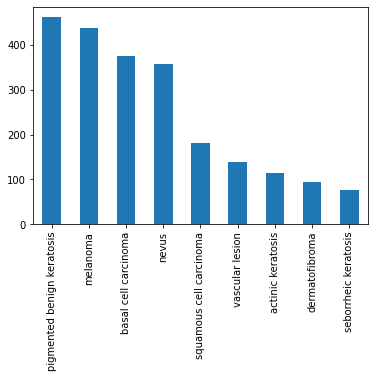

In [44]:
original_df.Label.value_counts().plot.bar()

From the above plot we can see the below responses
#### - Which class has the least number of samples?
- **pigmented benign keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
- **seborrheic keratosis**

### To Rectify Class Imabalance
We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [45]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [46]:
!ls "/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


In [47]:
path_to_training_dataset="/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

In [48]:
import Augmentor

In [49]:
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD1A2199C18>: 100%|██████████| 500/500 [00:17<00:00, 27.89 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD190557C50>: 100%|██████████| 500/500 [00:18<00:00, 27.59 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1FAA96F98>: 100%|██████████| 500/500 [00:19<00:00, 25.97 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD1F00401D0>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FD1F8EBDE10>: 100%|██████████| 500/500 [01:19<00:00,  6.31 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1F007DCF8>: 100%|██████████| 500/500 [00:18<00:00, 26.60 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD1F0172F98>: 100%|██████████| 500/500 [00:40<00:00, 12.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1F005C320>: 100%|██████████| 500/500 [00:18<00:00, 27.32 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD190422DA0>: 100%|██████████| 500/500 [00:19<00:00, 26.27 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [50]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [51]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_64d2a7ee-db5f-43bc-b5bc-d7e675a28d8f.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_c3924b72-9ca1-4c7d-89fd-5e7a6cf23d83.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028990.jpg_008d9e52-7cc6-4c1b-8c16-96f3ae0640ab.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_ea66e186-5cd8-40a9-8be6-9495eee36a4e.jpg',
 '/content/drive/My Drive/CNN_assignment_unzip/Skin cancer ISIC The International Skin Imagi

In [52]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [53]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [54]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

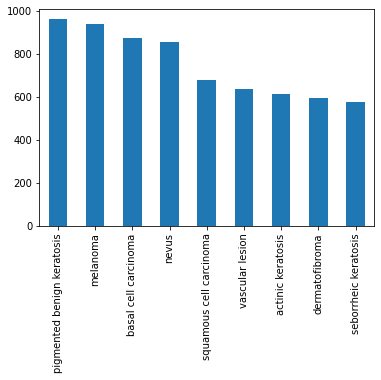

In [55]:
new_df['Label'].value_counts().plot.bar()

In [56]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process. 
We can see in the above graph and the classes are much more balanced now,

#### **Todo**: Train the model on the data created using Augmentor

In [57]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [58]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [60]:
## your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(num_classes, activation='softmax')
  
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [61]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 43, 43, 32)       

#### **Todo:**  Train your model

In [63]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 39s 221ms/step - loss: 2.2443 - accuracy: 0.1696 - val_loss: 1.7316 - val_accuracy: 0.3571
Epoch 2/30
169/169 [==============================] - 38s 220ms/step - loss: 1.6522 - accuracy: 0.3685 - val_loss: 1.5169 - val_accuracy: 0.4677
Epoch 3/30
169/169 [==============================] - 39s 222ms/step - loss: 1.3961 - accuracy: 0.4750 - val_loss: 1.3672 - val_accuracy: 0.5048
Epoch 4/30
169/169 [==============================] - 38s 220ms/step - loss: 1.2797 - accuracy: 0.5308 - val_loss: 1.3761 - val_accuracy: 0.4937
Epoch 5/30
169/169 [==============================] - 38s 220ms/step - loss: 1.1834 - accuracy: 0.5669 - val_loss: 1.3555 - val_accuracy: 0.4981
Epoch 6/30
169/169 [==============================] - 38s 221ms/step - loss: 1.1075 - accuracy: 0.6035 - val_loss: 1.1708 - val_accuracy: 0.5746
Epoch 7/30
169/169 [==============================] - 38s 220ms/step - loss: 1.0359 - accuracy: 0.6210 - val_loss: 1.1607 - val_ac

#### **Todo:**  Visualize the model results

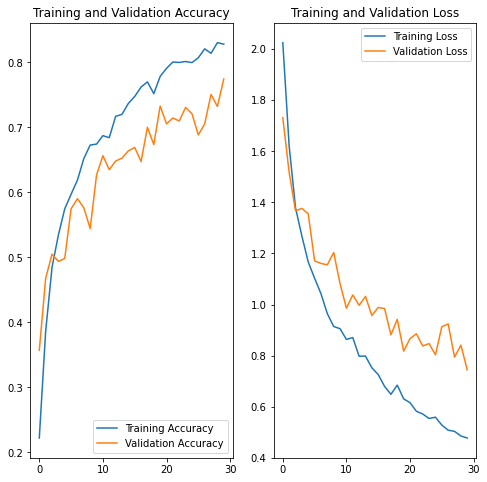

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Conclusion : 
- From the above graph we can see that the Accuracy has vastly improved after balancing the dataset and including the dropout layer.
- The current Training accuracy is at 82% and Validation Accuracy is at 77.43%
- The overfitting issue has been solved we can see significant improvment in Accuracy.
